In [11]:
import numpy as np
import pandas as pd

import tensorflow as tf
import pickle

In [1]:
dataset_path = r'dataset\training1600000.csv'

In [3]:
df = pd.read_csv(dataset_path, engine='python')

In [4]:
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [5]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "TweetText"]
df.columns = DATASET_COLUMNS

In [6]:
df.head()

,target,ids,date,flag,user,TweetText
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [7]:
keyword = 'depression'
keyword_count=df['TweetText'].str.lower().str.contains(keyword).sum()
print(keyword_count)

252


We see that at least we do not have a pure mapping for depression to keyword depression in our dataset

First, without any EDA, let's check out how some simple mondel deals with unprocessed text

In [8]:
data, target = df['TweetText'].values, df['target'].values
target[target==4] = 1

In [13]:
class_mapping = {0 : 'Negative tweet', 1: 'Positive tweet'}

with open(r'artifacts/class_mapping.pkl', 'wb') as handle:
    pickle.dump(class_mapping, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, stratify=target, random_state=13)

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAXLEN = 50

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

with open(r'artifacts/tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
def basic_data_preprocessing(data):
    data_tokenized = tokenizer.texts_to_sequences(data)
    data_padded = pad_sequences(data_tokenized, maxlen=MAXLEN)
    return data_padded

In [14]:
X_train_ready, X_test_ready = basic_data_preprocessing(X_train), basic_data_preprocessing(X_test)

In [15]:
from tensorflow.keras import layers
from tensorflow.keras import Sequential

In [16]:
def simple_lstm_model(num_words=10000, max_len=100):
    model = Sequential()
    model.add(layers.Embedding(num_words, 16, input_length=max_len))
    model.add(layers.LSTM(32))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [51]:
word_count = len(tokenizer.index_word.keys())+1

In [52]:
model = simple_lstm_model(num_words=word_count, max_len=MAXLEN)

In [55]:
from tensorflow.keras.optimizers import Adam

In [56]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_ready, y_train, epochs=6, batch_size=512, validation_split=0.2)

We see that just after 2-3 epochs, the model starts to overfit, the training even stabilizes after the first epoch!

In [65]:
model.evaluate(X_test, y_test)

500/500 [==============================] - 2s 3ms/step - loss: 0.4812 - accuracy: 0.7895


[0.48115819692611694, 0.7895351648330688]

We have quite good generalization, as the model achieves similar results on test set

For sure, we need to play with different models throughout our experimenting, as probably the model proposed is not the best for the job. But first, let's look at the data itself.

In [18]:
df.head()

,target,ids,date,flag,user,TweetText
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [47]:
post_count_per_user = df.groupby('user').count()
post_count_per_user.sort_values('target', ascending=False, inplace=True)
post_count_per_user.head()

,target,ids,date,flag,TweetText
user,,,,,
lost_dog,549,549,549,549,549
webwoke,345,345,345,345,345
tweetpet,310,310,310,310,310
SallytheShizzle,281,281,281,281,281
VioletsCRUK,279,279,279,279,279


In [51]:
post_sum_per_user = df.groupby('user').sum()
post_sum_per_user.sort_values('target', ascending=False, inplace=True)
post_sum_per_user.head()

,target,ids
user,,
what_bugs_u,246,496437036751
DarkPiano,231,452683872083
VioletsCRUK,218,548587797760
tsarnick,212,449787894006
keza34,211,414531380912


We see, that all the posts given by one user do not have the same class. That means, that every person can post depressed or 'undepressed' posts

In [40]:
print(f"Number of different users: {post_count_per_user.shape[0]}")

Number of different users: 659775


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

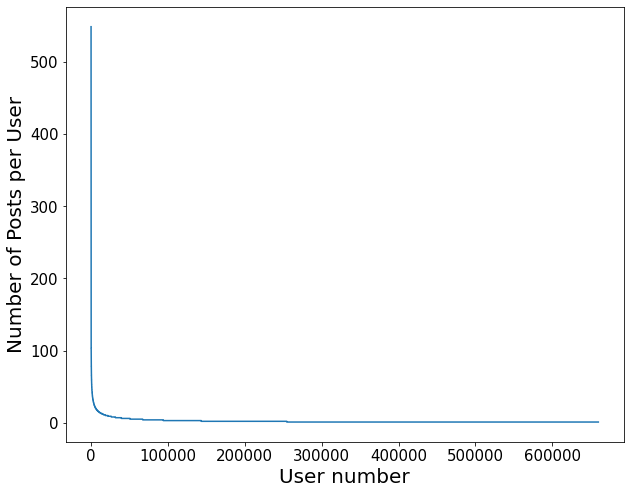

In [39]:
plt.figure(figsize=(10, 8))

plt.plot(post_count_per_user['TweetText'].values)
#ax.set_yticklabels([to_thousands(tick) for tick in ax.get_yticks()])
plt.tick_params(labelsize=15)
plt.ylabel('Number of Posts per User', fontsize=20)
plt.xlabel('User number', fontsize=20)
plt.show()

We see that the majority of users posted several posts, whereas a small percentage of users contributes to large portion of posts

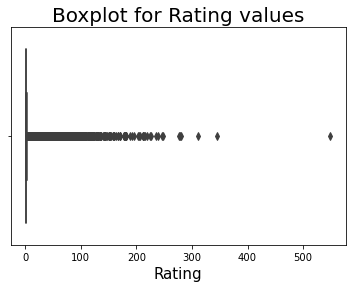

In [52]:
sns.boxplot(post_count_per_user['TweetText'].values)
plt.xlabel('Rating', fontsize=15)
plt.title('Boxplot for Rating values', fontsize=20)
plt.show()

The boxplot is so narrow that we cannot even see it!

In [53]:
post_count_per_user['TweetText'].describe()

count    659775.000000
mean          2.425068
std           4.710913
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         549.000000
Name: TweetText, dtype: float64

Yup, can confirm that. Mean post count is 2.42

In [67]:
word_count = list(tokenizer.word_counts)

In [63]:
words = list(word_count.keys())
counts = list(word_count.values())

In [77]:
word_df = pd.DataFrame(columns=['Word_Count'], data=counts, index=words)
word_df.sort_values('Word_Count', inplace=True, ascending=False)
word_df.head()

,Word_Count
i,617106
to,452566
the,419430
a,306063
my,253082


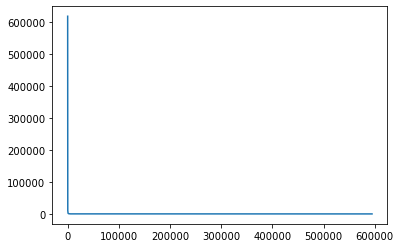

In [78]:
plt.plot(word_df.values)

Again, we see that really a small number of words is used over and over, and a majority of words are rarely compared to most common

In [85]:
bins = [0, 2, 5, 10, 30, 100, 1000, 10000, 100000, np.inf]
names = ['<2', '2-5', '5-10', '10-30', '30-100', '100-1000', '1000-10000', '10000-100000', '100000+']
word_df['Word_bin'] = pd.cut(word_df['Word_Count'], bins, labels=names)

([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text major ticklabel objects>)

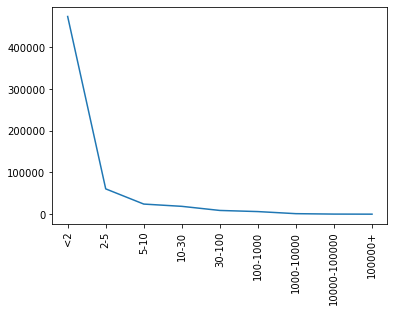

In [86]:
plt.plot(word_df['Word_bin'].value_counts())
plt.xticks(rotation=90)

We see, that there is a very large number of words, that happen to occur less than 5 times in our dataset.

In [89]:
from wordcloud import WordCloud

Let's see what are the most common words in our dataset

In [92]:
data = df['TweetText'].values

In [95]:
data

array(["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
       '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds',
       'my whole body feels itchy and like its on fire ', ...,
       'Are you ready for your MoJo Makeover? Ask me for details ',
       'Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur ',
       'happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H '],
      dtype=object)

In [108]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)

In [110]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [112]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Wojtek\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [113]:
df['CleanTweet'] = df['TweetText'].map(lambda x: preprocess(x))

In [114]:
df.head()

,target,ids,date,flag,user,TweetText,CleanTweet
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dived many times ball managed save re...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole body feels itchy like fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behaving mad see
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew,kwesidei whole crew


In [97]:
words = data.flatten()

In [102]:
words = words.astype(np.str)

In [104]:
words.dtype

dtype('<U374')

In [105]:
wordcloud = WordCloud(max_font_size=40).generate(words)

TypeError: cannot use a string pattern on a bytes-like object